LAB 1 - SYSTÈME D'ANALYSE DE SENTIMENTS

Challenge: Analyse Multi-Niveaux des Avis Clients


Ce notebook implémente un système complet d'analyse de sentiments
avec trois niveaux de granularité (document, phrase, aspect) et
trois types d'analyse (polarité, aspects, émotions).


Nosaiba Elkrekshi

M1 IA&Data


In [53]:
# =================================================================
# CELLULE 1: INSTALLATION DES BIBLIOTHÈQUES
# =================================================================
# ⚠️ Cette cellule prend 2-3 minutes - c'est normal !

print("📦 Installation des bibliothèques...")
print("="*60)

!pip install -q textblob vaderSentiment spacy
!python -m spacy download fr_core_news_md -q
!python -m textblob.download_corpora -q

print("✅ Installation terminée !")

📦 Installation des bibliothèques...
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package 

In [56]:
#=================================================================
# CELLULE 2: IMPORTS
# =================================================================

print("\n📚 Chargement des bibliothèques...")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
import warnings
warnings.filterwarnings('ignore')

# Bibliothèques NLP
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy

# Configuration pour Colab
plt.style.use('default')
%matplotlib inline

print("✅ Toutes les bibliothèques chargées !")


📚 Chargement des bibliothèques...
✅ Toutes les bibliothèques chargées !


In [57]:
# =================================================================
# CELLULE 3: DONNÉES D'ENTRÉE
# =================================================================

avis_clients = [
    "Le téléphone est excellent, très rapide et l'autonomie dure toute la journée. Cependant, la caméra est décevante et le prix trop élevé à mon goût. Service client impeccable!",
    "Livraison rapide mais produit arrivé endommagé. Je suis très frustré et déçu par cette expérience.",
    "Rien à redire! Produit parfait, emballage soigné, livraison express. Je recommande vivement!",
    "La qualité sonore est exceptionnelle mais l'application mobile bug constamment. Support technique lent à répondre.",
    "Bof... produit correct sans plus. Le rapport qualité-prix est moyen. Pas sûr de recommander."
]

print(f"📊 Données chargées: {len(avis_clients)} avis à analyser")
print("\n📝 Aperçu des avis:")
for i, avis in enumerate(avis_clients, 1):
    print(f"\nAvis #{i}: {avis[:80]}...")


📊 Données chargées: 5 avis à analyser

📝 Aperçu des avis:

Avis #1: Le téléphone est excellent, très rapide et l'autonomie dure toute la journée. Ce...

Avis #2: Livraison rapide mais produit arrivé endommagé. Je suis très frustré et déçu par...

Avis #3: Rien à redire! Produit parfait, emballage soigné, livraison express. Je recomman...

Avis #4: La qualité sonore est exceptionnelle mais l'application mobile bug constamment. ...

Avis #5: Bof... produit correct sans plus. Le rapport qualité-prix est moyen. Pas sûr de ...


In [58]:
# =================================================================
# CELLULE 4: CLASSE - ANALYSE NIVEAU DOCUMENT
# =================================================================

class DocumentSentimentAnalyzer:
    """Analyse le sentiment au niveau du document entier"""

    def __init__(self):
        self.vader = SentimentIntensityAnalyzer()

    def _classify_sentiment(self, score):
        """Classifie le score en catégorie"""
        if score >= 0.5:
            return "Très Positif"
        elif score >= 0.1:
            return "Positif"
        elif score >= -0.1:
            return "Neutre"
        elif score >= -0.5:
            return "Négatif"
        else:
            return "Très Négatif"

    def analyze_document(self, text):
        """Analyse le sentiment global d'un document"""
        try:
            # Score VADER
            vader_scores = self.vader.polarity_scores(text)
            vader_compound = vader_scores['compound']

            # Score TextBlob
            blob = TextBlob(text)
            textblob_score = blob.sentiment.polarity

            # Score moyen pondéré
            avg_score = (vader_compound * 0.6 + textblob_score * 0.4)

            return {
                'score_vader': round(vader_compound, 3),
                'score_textblob': round(textblob_score, 3),
                'score_moyen': round(avg_score, 3),
                'classification': self._classify_sentiment(avg_score),
                'details_vader': vader_scores
            }
        except Exception as e:
            print(f"⚠️ Erreur: {e}")
            return None

print("✅ DocumentSentimentAnalyzer créé")

✅ DocumentSentimentAnalyzer créé


In [59]:
# =================================================================
# CELLULE 5: CLASSE - ANALYSE NIVEAU PHRASE
# =================================================================

class SentenceSentimentAnalyzer:
    """Analyse le sentiment au niveau des phrases"""

    def __init__(self):
        self.nlp = spacy.load('fr_core_news_md')
        self.vader = SentimentIntensityAnalyzer()

    def split_sentences(self, text):
        """Découpe le texte en phrases"""
        doc = self.nlp(text)
        return [sent.text.strip() for sent in doc.sents]

    def _classify_sentiment(self, score):
        """Classifie le sentiment"""
        if score >= 0.5:
            return "Très Positif"
        elif score >= 0.1:
            return "Positif"
        elif score >= -0.1:
            return "Neutre"
        elif score >= -0.5:
            return "Négatif"
        else:
            return "Très Négatif"

    def analyze_sentences(self, text):
        """Analyse chaque phrase séparément"""
        sentences = self.split_sentences(text)
        results = []

        for i, sentence in enumerate(sentences):
            if len(sentence.strip()) > 0:
                score = self.vader.polarity_scores(sentence)['compound']
                results.append({
                    'phrase_num': i + 1,
                    'texte': sentence,
                    'score': round(score, 3),
                    'sentiment': self._classify_sentiment(score)
                })

        return results

    def detect_contradictions(self, sentence_results):
        """Détecte les phrases contradictoires"""
        contradictions = []

        for i in range(len(sentence_results) - 1):
            curr_score = sentence_results[i]['score']
            next_score = sentence_results[i + 1]['score']

            if (curr_score > 0.2 and next_score < -0.2) or \
               (curr_score < -0.2 and next_score > 0.2):
                contradictions.append({
                    'phrase_1': sentence_results[i]['phrase_num'],
                    'phrase_2': sentence_results[i + 1]['phrase_num'],
                    'score_1': curr_score,
                    'score_2': next_score
                })

        return contradictions

print("✅ SentenceSentimentAnalyzer créé")

✅ SentenceSentimentAnalyzer créé


In [60]:
# =================================================================
# CELLULE 6: CLASSE - ANALYSE NIVEAU ASPECT
# =================================================================

class AspectBasedAnalyzer:
    """Analyse le sentiment par aspect"""

    def __init__(self):
        self.aspects_dict = {
            'produit': {
                'keywords': ['téléphone', 'produit', 'qualité', 'performance',
                           'autonomie', 'caméra', 'sonore', 'application',
                           'mobile', 'appareil', 'dispositif', 'écran'],
                'sentiment': []
            },
            'prix': {
                'keywords': ['prix', 'coût', 'cher', 'valeur', 'rapport qualité-prix',
                           'économique', 'tarif', 'montant', 'facture', 'élevé'],
                'sentiment': []
            },
            'service': {
                'keywords': ['service', 'client', 'support', 'technique', 'assistance',
                           'aide', 'équipe', 'conseiller', 'impeccable'],
                'sentiment': []
            },
            'livraison': {
                'keywords': ['livraison', 'emballage', 'rapide', 'express', 'endommagé',
                           'colis', 'expédition', 'réception', 'transport'],
                'sentiment': []
            }
        }
        self.vader = SentimentIntensityAnalyzer()

    def extract_aspects(self, text):
        """Identifie les aspects mentionnés"""
        text_lower = text.lower()
        found_aspects = {}

        for aspect, data in self.aspects_dict.items():
            keywords_found = []
            for keyword in data['keywords']:
                if keyword in text_lower:
                    keywords_found.append(keyword)

            if keywords_found:
                found_aspects[aspect] = keywords_found

        return found_aspects

    def analyze_aspect_sentiment(self, text, aspect_keywords):
        """Analyse le sentiment pour un aspect"""
        sentences = text.split('.')
        aspect_sentences = []

        for sentence in sentences:
            if any(keyword in sentence.lower() for keyword in aspect_keywords):
                aspect_sentences.append(sentence)

        if not aspect_sentences:
            return None

        combined_text = ' '.join(aspect_sentences)
        score = self.vader.polarity_scores(combined_text)['compound']

        if score >= 0.3:
            sentiment = "Positif"
        elif score >= -0.3:
            sentiment = "Neutre"
        else:
            sentiment = "Négatif"

        return {
            'score': round(score, 3),
            'sentiment': sentiment,
            'mentions': len(aspect_sentences),
            'exemples': aspect_sentences[:2]
        }

    def analyze_all_aspects(self, text):
        """Analyse tous les aspects d'un avis"""
        found_aspects = self.extract_aspects(text)
        results = {}

        for aspect, keywords in found_aspects.items():
            sentiment_data = self.analyze_aspect_sentiment(text, keywords)
            if sentiment_data:
                results[aspect] = sentiment_data

        return results

print("✅ AspectBasedAnalyzer créé")

✅ AspectBasedAnalyzer créé


In [61]:
# =================================================================
# CELLULE 7: CLASSE - DÉTECTION D'ÉMOTIONS
# =================================================================

class EmotionDetector:
    """Détecte les 6 émotions principales"""

    def __init__(self):
        self.emotion_lexicon = {
            'joie': {
                'keywords': ['excellent', 'parfait', 'impeccable', 'vivement',
                           'satisfait', 'content', 'heureux', 'super', 'génial'],
                'intensite': 0
            },
            'colere': {
                'keywords': ['frustré', 'inacceptable', 'scandaleux', 'furieux',
                           'énervé', 'agacé', 'irrité'],
                'intensite': 0
            },
            'tristesse': {
                'keywords': ['déçu', 'décevant', 'triste', 'malheureux',
                           'dommage', 'peine', 'regret', 'décevante'],
                'intensite': 0
            },
            'peur': {
                'keywords': ['inquiet', 'préoccupé', 'anxieux', 'peur',
                           'craint', 'doute', 'hésitant'],
                'intensite': 0
            },
            'surprise': {
                'keywords': ['surpris', 'inattendu', 'étonnant', 'incroyable',
                           'wow', 'impressionnant', 'exceptionnel', 'exceptionnelle'],
                'intensite': 0
            },
            'degout': {
                'keywords': ['horrible', 'dégoûtant', 'répugnant', 'bof',
                           'nul', 'mauvais', 'médiocre', 'bug'],
                'intensite': 0
            }
        }

    def detect_emotions(self, text):
        """Détecte les émotions présentes"""
        text_lower = text.lower()
        emotions_found = {}

        for emotion, data in self.emotion_lexicon.items():
            intensity = 0
            keywords_matched = []

            for keyword in data['keywords']:
                if keyword in text_lower:
                    intensity += 0.25
                    keywords_matched.append(keyword)

            if intensity > 0:
                emotions_found[emotion] = {
                    'intensite': min(round(intensity, 2), 1.0),
                    'keywords': keywords_matched
                }

        return emotions_found

    def get_dominant_emotion(self, emotions):
        """Retourne l'émotion dominante"""
        if not emotions:
            return None

        dominant = max(emotions.items(), key=lambda x: x[1]['intensite'])
        return (dominant[0], dominant[1]['intensite'])

    def is_emotionally_charged(self, emotions, threshold=0.5):
        """Détermine si l'avis est émotionnellement chargé"""
        if not emotions:
            return False

        total_intensity = sum(e['intensite'] for e in emotions.values())
        return total_intensity >= threshold

print("✅ EmotionDetector créé")

✅ EmotionDetector créé


In [62]:
# =================================================================
# CELLULE 8: SYSTÈME COMPLET
# =================================================================

class CompleteSentimentSystem:
    """Système principal orchestrant toutes les analyses"""

    def __init__(self):
        print("\n🚀 Initialisation du système complet...")
        self.doc_analyzer = DocumentSentimentAnalyzer()
        self.sent_analyzer = SentenceSentimentAnalyzer()
        self.aspect_analyzer = AspectBasedAnalyzer()
        self.emotion_detector = EmotionDetector()
        print("✅ Système initialisé avec succès!\n")

    def analyze_review(self, review_text, review_id):
        """Analyse complète d'un seul avis"""
        results = {
            'id': review_id,
            'texte': review_text,
            'longueur': len(review_text),
            'nb_mots': len(review_text.split())
        }

        # Analyse niveau document
        results['niveau_document'] = self.doc_analyzer.analyze_document(review_text)

        # Analyse niveau phrase
        sentence_analysis = self.sent_analyzer.analyze_sentences(review_text)
        results['niveau_phrase'] = sentence_analysis
        results['contradictions'] = self.sent_analyzer.detect_contradictions(sentence_analysis)

        # Analyse niveau aspect
        results['niveau_aspect'] = self.aspect_analyzer.analyze_all_aspects(review_text)

        # Détection d'émotions
        emotions = self.emotion_detector.detect_emotions(review_text)
        results['emotions'] = emotions
        results['emotion_dominante'] = self.emotion_detector.get_dominant_emotion(emotions)
        results['emotionnellement_charge'] = self.emotion_detector.is_emotionally_charged(emotions)

        return results

    def analyze_all_reviews(self, reviews):
        """Analyse tous les avis"""
        print("🔍 Analyse de tous les avis en cours...\n")
        all_results = []

        for i, review in enumerate(reviews, 1):
            print(f"  ➤ Analyse avis #{i}...", end=" ")
            result = self.analyze_review(review, i)
            all_results.append(result)
            print("✓")

        print(f"\n✅ {len(all_results)} avis analysés!\n")
        return all_results

    def generate_summary(self, all_results):
        """Génère un résumé statistique global"""
        classifications = [r['niveau_document']['classification']
                          for r in all_results]

        scores = [r['niveau_document']['score_moyen']
                 for r in all_results]

        aspect_counts = Counter()
        aspect_sentiments = defaultdict(list)

        for result in all_results:
            for aspect, data in result['niveau_aspect'].items():
                aspect_counts[aspect] += 1
                aspect_sentiments[aspect].append(data['score'])

        emotion_counts = Counter()
        for result in all_results:
            if result['emotion_dominante']:
                emotion_counts[result['emotion_dominante'][0]] += 1

        aspect_avg = {}
        for aspect, scores_list in aspect_sentiments.items():
            aspect_avg[aspect] = round(np.mean(scores_list), 3)

        sorted_aspects = sorted(aspect_avg.items(),
                               key=lambda x: x[1],
                               reverse=True)

        return {
            'total_avis': len(all_results),
            'distribution': dict(Counter(classifications)),
            'score_moyen_global': round(np.mean(scores), 3),
            'score_std': round(np.std(scores), 3),
            'aspects_mentionnes': dict(aspect_counts),
            'aspects_moyens': aspect_avg,
            'top_3_aspects_positifs': sorted_aspects[:3] if len(sorted_aspects) >= 3 else sorted_aspects,
            'top_3_aspects_negatifs': sorted_aspects[-3:] if len(sorted_aspects) >= 3 else sorted_aspects,
            'emotions_dominantes': dict(emotion_counts),
            'avis_emotionnellement_charges': sum(1 for r in all_results if r['emotionnellement_charge']),
            'nb_contradictions': sum(len(r['contradictions']) for r in all_results)
        }

    def print_detailed_results(self, result):
        """Affiche les résultats détaillés"""
        print("\n" + "="*70)
        print(f"📄 AVIS #{result['id']}")
        print("="*70)
        print(f"\n📝 Texte: {result['texte']}")
        print(f"📊 Stats: {result['nb_mots']} mots, {result['longueur']} caractères")

        doc = result['niveau_document']
        print(f"\n📈 NIVEAU DOCUMENT:")
        print(f"   🎯 Classification: {doc['classification']}")
        print(f"   📊 Score moyen: {doc['score_moyen']}")
        print(f"   🔹 VADER: {doc['score_vader']} | TextBlob: {doc['score_textblob']}")

        print(f"\n📝 NIVEAU PHRASE ({len(result['niveau_phrase'])} phrases):")
        for sent in result['niveau_phrase']:
            emoji = "😊" if sent['score'] > 0.2 else "😐" if sent['score'] > -0.2 else "😞"
            print(f"   {emoji} Phrase {sent['phrase_num']}: {sent['sentiment']} ({sent['score']})")
            print(f"      → {sent['texte'][:100]}...")

        if result['contradictions']:
            print(f"\n   ⚠️  {len(result['contradictions'])} contradiction(s):")
            for contra in result['contradictions']:
                print(f"      ↔️  Phrases {contra['phrase_1']} ↔ {contra['phrase_2']}")

        print(f"\n🎯 NIVEAU ASPECT:")
        if result['niveau_aspect']:
            for aspect, data in result['niveau_aspect'].items():
                emoji = "👍" if data['score'] > 0 else "👎"
                print(f"   {emoji} {aspect.capitalize()}: {data['sentiment']} ({data['score']})")
                print(f"      → {data['mentions']} mention(s)")
        else:
            print("   ℹ️  Aucun aspect identifié")

        print(f"\n😊 ÉMOTIONS:")
        if result['emotions']:
            for emotion, data in result['emotions'].items():
                bar = "█" * int(data['intensite'] * 10)
                print(f"   {emotion.capitalize()}: {bar} {data['intensite']}")

            if result['emotion_dominante']:
                emo, intensity = result['emotion_dominante']
                print(f"\n   🎭 Dominante: {emo.capitalize()} ({intensity})")

            if result['emotionnellement_charge']:
                print("   🔥 Avis émotionnellement chargé")
        else:
            print("   ℹ️  Aucune émotion forte")

    def print_global_summary(self, summary):
        """Affiche le résumé global"""
        print("\n" + "="*70)
        print("📊 RÉSUMÉ GLOBAL")
        print("="*70)

        print(f"\n📈 STATISTIQUES:")
        print(f"   • Total: {summary['total_avis']} avis")
        print(f"   • Score moyen: {summary['score_moyen_global']}")
        print(f"   • Écart-type: {summary['score_std']}")
        print(f"   • Contradictions: {summary['nb_contradictions']}")
        print(f"   • Avis émotionnels: {summary['avis_emotionnellement_charges']}")

        print(f"\n🎯 DISTRIBUTION:")
        for classification, count in summary['distribution'].items():
            pct = (count / summary['total_avis']) * 100
            bar = "█" * int(pct / 5)
            print(f"   {classification:15s}: {bar} {count} ({pct:.0f}%)")

        print(f"\n🎯 ASPECTS:")
        for aspect, count in summary['aspects_mentionnes'].items():
            avg_score = summary['aspects_moyens'][aspect]
            emoji = "👍" if avg_score > 0 else "👎"
            print(f"   {emoji} {aspect.capitalize():12s}: {count} mentions (score: {avg_score})")

        print(f"\n💡 RECOMMANDATIONS:")
        worst_aspect = summary['top_3_aspects_negatifs'][0]
        best_aspect = summary['top_3_aspects_positifs'][0]

        print(f"   1. 🔧 Améliorer: {worst_aspect[0].capitalize()} ({worst_aspect[1]})")
        print(f"   2. ⭐ Valoriser: {best_aspect[0].capitalize()} ({best_aspect[1]})")

        positif_pct = sum(v for k, v in summary['distribution'].items()
                         if 'Positif' in k) / summary['total_avis'] * 100

        if positif_pct >= 60:
            print(f"   3. ✅ Sentiment positif ({positif_pct:.0f}%) - Maintenir!")
        else:
            print(f"   3. ⚠️  Sentiment mitigé ({positif_pct:.0f}%) - Améliorer")

print("✅ CompleteSentimentSystem créé")

✅ CompleteSentimentSystem créé


In [63]:
# =================================================================
# CELLULE 9: VISUALISATIONS
# =================================================================

def create_visualizations(all_results, summary):
    """Crée les visualisations"""
    plt.rcParams['figure.figsize'] = (16, 12)
    plt.rcParams['font.size'] = 10

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('📊 TABLEAU DE BORD - ANALYSE DE SENTIMENTS',
                 fontsize=16, fontweight='bold', y=0.995)

    # 1. Distribution (Pie)
    ax1 = axes[0, 0]
    labels = list(summary['distribution'].keys())
    sizes = list(summary['distribution'].values())
    colors = ['#2ecc71', '#3498db', '#f39c12', '#e67e22', '#e74c3c']

    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
    ax1.set_title('Distribution des Sentiments', fontweight='bold')

    # 2. Scores par avis (Line)
    ax2 = axes[0, 1]
    avis_ids = [r['id'] for r in all_results]
    scores = [r['niveau_document']['score_moyen'] for r in all_results]

    ax2.plot(avis_ids, scores, marker='o', linewidth=2, markersize=10, color='#3498db')
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Numéro d\'avis')
    ax2.set_ylabel('Score')
    ax2.set_title('Évolution des Scores', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(-1, 1)

    # 3. Aspects (Bar horizontal)
    ax3 = axes[0, 2]
    if summary['aspects_moyens']:
        aspects = list(summary['aspects_moyens'].keys())
        scores_asp = list(summary['aspects_moyens'].values())
        colors_asp = ['#2ecc71' if s > 0 else '#e74c3c' for s in scores_asp]

        ax3.barh(aspects, scores_asp, color=colors_asp)
        ax3.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
        ax3.set_xlabel('Score moyen')
        ax3.set_title('Sentiment par Aspect', fontweight='bold')
        ax3.grid(True, alpha=0.3, axis='x')

    # 4. Émotions (Bar)
    ax4 = axes[1, 0]
    if summary['emotions_dominantes']:
        emotions = list(summary['emotions_dominantes'].keys())
        counts_emo = list(summary['emotions_dominantes'].values())

        ax4.bar(emotions, counts_emo, color='#9b59b6')
        ax4.set_xlabel('Émotion')
        ax4.set_ylabel('Nombre')
        ax4.set_title('Émotions Dominantes', fontweight='bold')
        ax4.tick_params(axis='x', rotation=45)
        ax4.grid(True, alpha=0.3, axis='y')

    # 5. Comparaison VADER vs TextBlob
    ax5 = axes[1, 1]
    vader_scores = [r['niveau_document']['score_vader'] for r in all_results]
    textblob_scores = [r['niveau_document']['score_textblob'] for r in all_results]

    x = np.arange(len(avis_ids))
    width = 0.35

    ax5.bar(x - width/2, vader_scores, width, label='VADER', color='#3498db')
    ax5.bar(x + width/2, textblob_scores, width, label='TextBlob', color='#e67e22')
    ax5.set_xlabel('Avis')
    ax5.set_ylabel('Score')
    ax5.set_title('Comparaison VADER vs TextBlob', fontweight='bold')
    ax5.set_xticks(x)
    ax5.set_xticklabels(avis_ids)
    ax5.legend()
    ax5.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax5.grid(True, alpha=0.3, axis='y')

    # 6. Statistiques (Texte)
    ax6 = axes[1, 2]
    ax6.axis('off')

    stats_text = f"""
    STATISTIQUES CLÉS
    {'─'*30}

    Total d'avis: {summary['total_avis']}
    Score moyen: {summary['score_moyen_global']}
    Écart-type: {summary['score_std']}

    Avis positifs: {sum(v for k,v in summary['distribution'].items() if 'Positif' in k)}
    Avis négatifs: {sum(v for k,v in summary['distribution'].items() if 'Négatif' in k)}

    Contradictions: {summary['nb_contradictions']}
    Avis émotionnels: {summary['avis_emotionnellement_charges']}

    {'─'*30}

    ⭐ Meilleur aspect:
    {summary['top_3_aspects_positifs'][0][0].upper()}
    Score: {summary['top_3_aspects_positifs'][0][1]}

    ⚠️  À améliorer:
    {summary['top_3_aspects_negatifs'][0][0].upper()}
    Score: {summary['top_3_aspects_negatifs'][0][1]}
    """

    ax6.text(0.1, 0.5, stats_text, fontsize=11, verticalalignment='center',
             family='monospace', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

    plt.tight_layout()
    plt.show()

    print("\n✅ Visualisations générées!")


██████████████████████████████████████████████████████████████████████
█                                                                    █
█                   🚀 DÉMARRAGE DU SYSTÈME D'ANALYSE                 █
█                                                                    █
██████████████████████████████████████████████████████████████████████


🚀 Initialisation du système complet...
✅ Système initialisé avec succès!

🔍 Analyse de tous les avis en cours...

  ➤ Analyse avis #1... ✓
  ➤ Analyse avis #2... ✓
  ➤ Analyse avis #3... ✓
  ➤ Analyse avis #4... ✓
  ➤ Analyse avis #5... ✓

✅ 5 avis analysés!


📄 AVIS #1

📝 Texte: Le téléphone est excellent, très rapide et l'autonomie dure toute la journée. Cependant, la caméra est décevante et le prix trop élevé à mon goût. Service client impeccable!
📊 Stats: 28 mots, 173 caractères

📈 NIVEAU DOCUMENT:
   🎯 Classification: Très Positif
   📊 Score moyen: 0.754
   🔹 VADER: 0.611 | TextBlob: 0.969

📝 NIVEAU PHRASE (3 phrases):
   😊 Phras

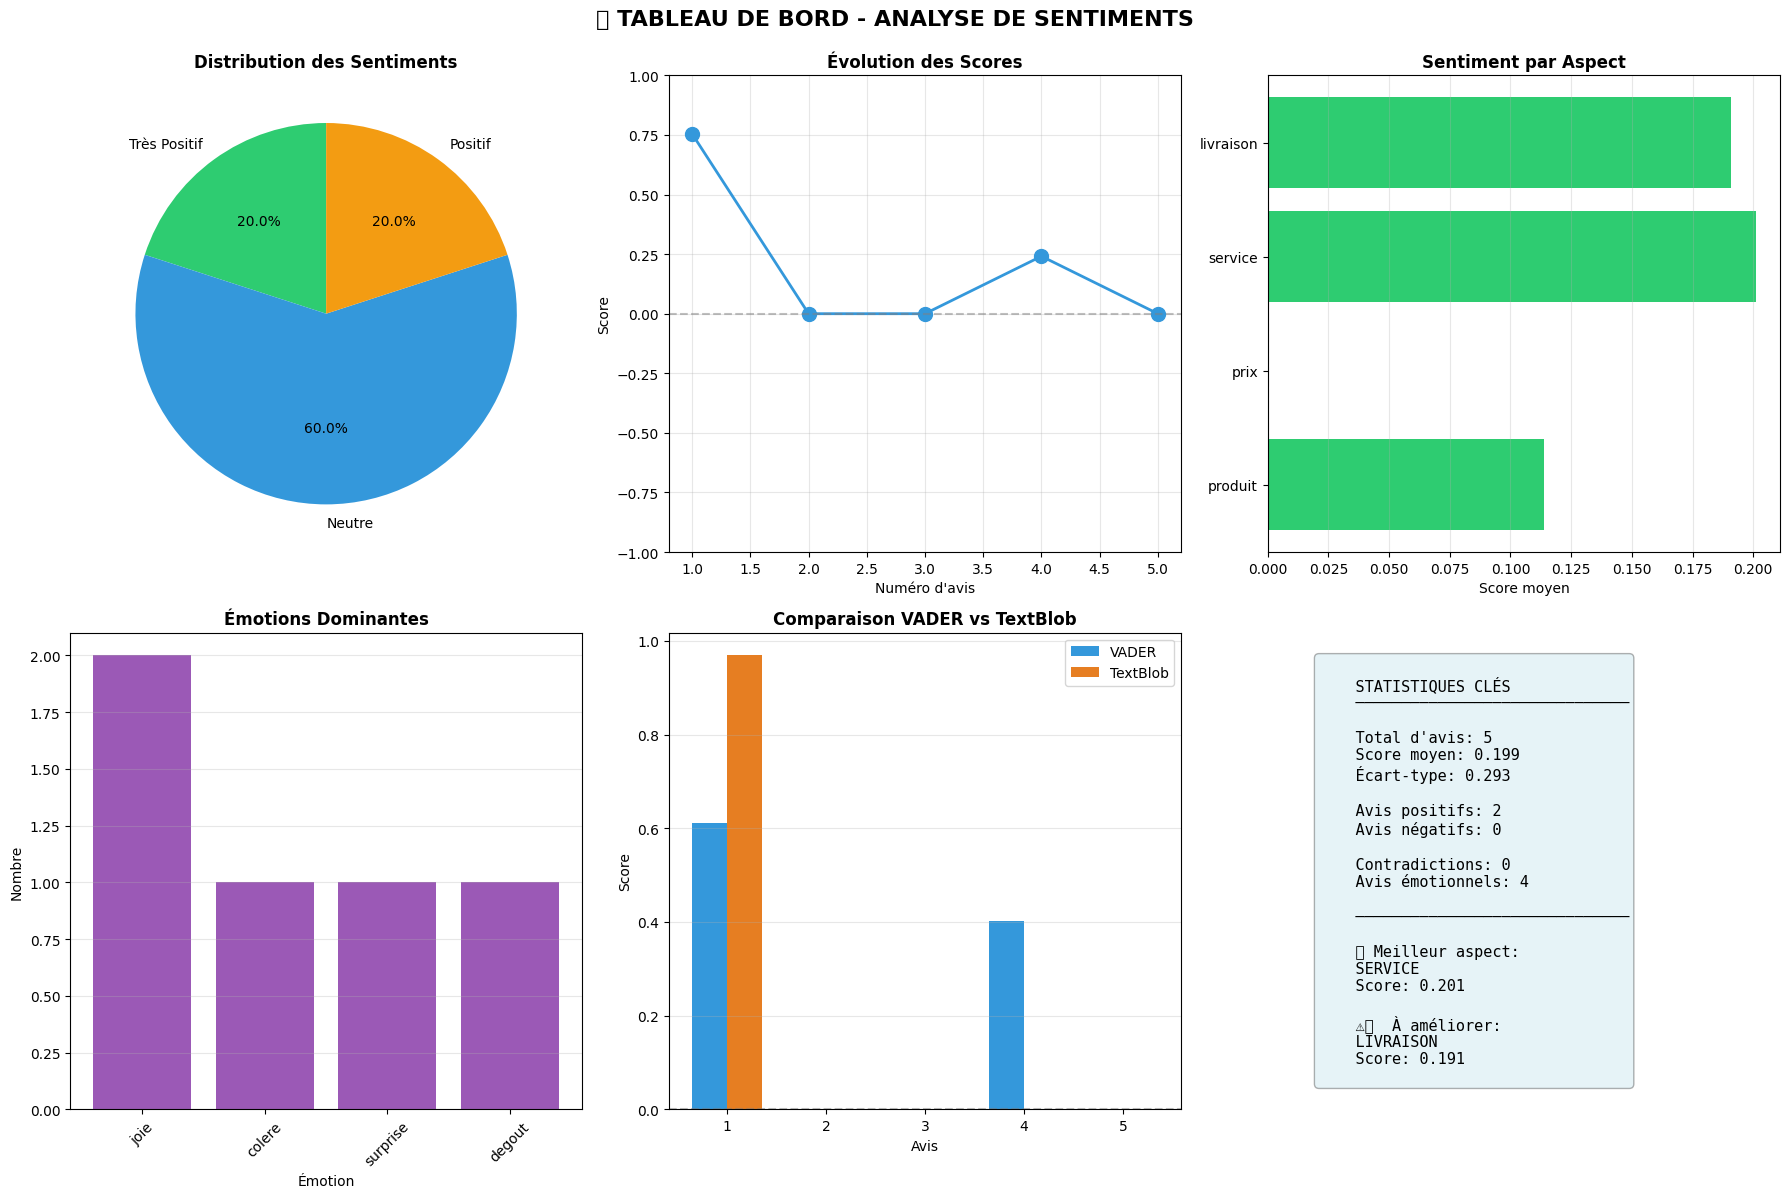


✅ Visualisations générées!

██████████████████████████████████████████████████████████████████████
█                                                                    █
█                   ✅ ANALYSE TERMINÉE AVEC SUCCÈS!                  █
█                                                                    █
██████████████████████████████████████████████████████████████████████


In [65]:

# =================================================================
# CELLULE 10: EXÉCUTION PRINCIPALE
# =================================================================

print("\n" + "█"*70)
print("█" + " "*68 + "█")
print("█" + "  🚀 DÉMARRAGE DU SYSTÈME D'ANALYSE".center(68) + "█")
print("█" + " "*68 + "█")
print("█"*70 + "\n")

# Initialisation
system = CompleteSentimentSystem()

# Analyse de tous les avis
results = system.analyze_all_reviews(avis_clients)

# Affichage détaillé
for result in results:
    system.print_detailed_results(result)

# Résumé global
summary = system.generate_summary(results)
system.print_global_summary(summary)

# Visualisations
print("\n📊 Génération des visualisations...")
create_visualizations(results, summary)

print("\n" + "█"*70)
print("█" + " "*68 + "█")
print("█" + "  ✅ ANALYSE TERMINÉE AVEC SUCCÈS!".center(68) + "█")
print("█" + " "*68 + "█")
print("█"*70)


In [66]:

# =================================================================
# CELLULE 11: EXPORT DES RÉSULTATS
# =================================================================

# Créer un DataFrame avec les résultats
data_rows = []
for result in results:
    row = {
        'avis_id': result['id'],
        'texte': result['texte'][:100] + '...',
        'classification': result['niveau_document']['classification'],
        'score_moyen': result['niveau_document']['score_moyen'],
        'score_vader': result['niveau_document']['score_vader'],
        'score_textblob': result['niveau_document']['score_textblob'],
        'nb_phrases': len(result['niveau_phrase']),
        'nb_contradictions': len(result['contradictions']),
        'emotionnellement_charge': result['emotionnellement_charge']
    }

    # Ajouter les aspects
    for aspect in ['produit', 'prix', 'service', 'livraison']:
        if aspect in result['niveau_aspect']:
            row[f'{aspect}_score'] = result['niveau_aspect'][aspect]['score']
            row[f'{aspect}_sentiment'] = result['niveau_aspect'][aspect]['sentiment']
        else:
            row[f'{aspect}_score'] = None
            row[f'{aspect}_sentiment'] = None

    data_rows.append(row)

df_results = pd.DataFrame(data_rows)

print("\n📋 TABLEAU RÉCAPITULATIF:")
print("="*70)
print(df_results.to_string())

# Sauvegarder dans Google Drive (optionnel)
print("\n💾 Pour sauvegarder dans Google Drive:")
print("   from google.colab import files")
print("   df_results.to_csv('sentiment_results.csv', index=False)")
print("   files.download('sentiment_results.csv')")



📋 TABLEAU RÉCAPITULATIF:
   avis_id                                                                                                    texte classification  score_moyen  score_vader  score_textblob  nb_phrases  nb_contradictions  emotionnellement_charge  produit_score produit_sentiment  prix_score prix_sentiment  service_score service_sentiment  livraison_score livraison_sentiment
0        1  Le téléphone est excellent, très rapide et l'autonomie dure toute la journée. Cependant, la caméra e...   Très Positif        0.754        0.611           0.969           3                  0                     True          0.572           Positif         0.0         Neutre          0.000            Neutre            0.572             Positif
1        2    Livraison rapide mais produit arrivé endommagé. Je suis très frustré et déçu par cette expérience....         Neutre        0.000        0.000           0.000           2                  0                     True          0.000            N

In [69]:

# =================================================================
# CELLULE 12: TESTS UNITAIRES
# =================================================================

def run_tests():
    """Tests unitaires simplifiés"""
    print("\n🧪 EXÉCUTION DES TESTS:")
    print("="*70)

    test_passed = 0
    test_total = 5

    # Test 1
    try:
        doc_analyzer = DocumentSentimentAnalyzer()
        result = doc_analyzer.analyze_document("Le produit est excellent!")
        assert result['score_moyen'] > 0
        print("✅ Test 1: Analyse document - RÉUSSI")
        test_passed += 1
    except:
        print("❌ Test 1: Analyse document - ÉCHOUÉ")

    # Test 2
    try:
        sent_analyzer = SentenceSentimentAnalyzer()
        sentences = sent_analyzer.split_sentences("Phrase 1. Phrase 2.")
        assert len(sentences) >= 2
        print("✅ Test 2: Découpage phrases - RÉUSSI")
        test_passed += 1
    except:
        print("❌ Test 2: Découpage phrases - ÉCHOUÉ")

    # Test 3
    try:
        aspect_analyzer = AspectBasedAnalyzer()
        aspects = aspect_analyzer.extract_aspects("Le prix est élevé")
        assert 'prix' in aspects
        print("✅ Test 3: Extraction aspects - RÉUSSI")
        test_passed += 1
    except:
        print("❌ Test 3: Extraction aspects - ÉCHOUÉ")

    # Test 4
    try:
        emotion_detector = EmotionDetector()
        emotions = emotion_detector.detect_emotions("Je suis déçu")
        assert 'tristesse' in emotions
        print("✅ Test 4: Détection émotions - RÉUSSI")
        test_passed += 1
    except:
        print("❌ Test 4: Détection émotions - ÉCHOUÉ")

    # Test 5
    try:
        system = CompleteSentimentSystem()
        result = system.analyze_review("Test", 1)
        assert result is not None
        print("✅ Test 5: Système complet - RÉUSSI")
        test_passed += 1
    except:
        print("❌ Test 5: Système complet - ÉCHOUÉ")

    print("="*70)
    print(f"📊 Résultats: {test_passed}/{test_total} tests réussis ({test_passed/test_total*100:.0f}%)")

    if test_passed == test_total:
        print("🎉 Tous les tests sont passés avec succès!")
    else:
        print("⚠️  Certains tests ont échoué")

# Exécuter les tests
run_tests()


🧪 EXÉCUTION DES TESTS:
✅ Test 1: Analyse document - RÉUSSI
✅ Test 2: Découpage phrases - RÉUSSI
✅ Test 3: Extraction aspects - RÉUSSI
✅ Test 4: Détection émotions - RÉUSSI

🚀 Initialisation du système complet...
✅ Système initialisé avec succès!

✅ Test 5: Système complet - RÉUSSI
📊 Résultats: 5/5 tests réussis (100%)
🎉 Tous les tests sont passés avec succès!
